In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

In [3]:
def ndi(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    
    NDI = 128 * ((G - R)/(G + R) + 1)
    
    return NDI.astype('uint8')

In [4]:
def exg(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    B = img[:, :, 2].astype(int)
    
    sum_RGB = R + G + B
    EXG = 64 *((2 * G - R - B) / sum_RGB + 2)
    
    return EXG.astype('uint8')

In [5]:
def cive(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    B = img[:, :, 2].astype(int)
    
    CIVE = 0.441 * R - 0.811 * G + 0.385 * B + 18.78745
    return CIVE.astype('uint8')

In [6]:
def exgr(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    B = img[:, :, 2].astype(int)
    
    ExR = 1.3 * R - G
    ExG = exg(img)
    
    return (ExG - ExR).astype('uint8')

In [29]:
def veg(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    B = img[:, :, 2].astype(int)
    
    a = 2/3
    VEG = G / ((R ** a) * (B ** (1 - a)))
    print(VEG)
    print(np.max(VEG), np.min(VEG))
    return VEG.astype('uint8')

In [31]:
def mexg(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    B = img[:, :, 2].astype(int)
    
    MExG = 1.262 * G - 0.884 * R - 0.311 * B
    return MExG.astype('uint8')

In [19]:
def otsu_binarization(img, verbose=False):
    blur = cv2.GaussianBlur(img,(5,5),0)
    th1, ret = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if verbose:
        print(th1)
    return th1, ret

In [20]:
def fixed_binarization(img, th = 131, verbose=False):
    blur = cv2.GaussianBlur(img,(5,5),0)
    th1, ret = cv2.threshold(blur,th,255,cv2.THRESH_BINARY)
    if verbose:
        print(th1)
    return th1, ret

In [21]:
def mean_binarization(img):
    th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    return th3

In [22]:
def imshow(img, verbose=True, gray=True):
    if verbose:
        plt.figure()
        if gray:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)

# Play around

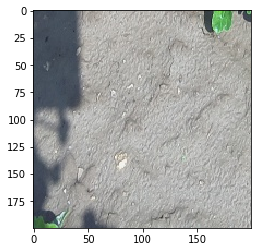

In [33]:
# Read image
img_cv = cv2.imread('data/im_109.jpg')
img = img_cv[:, :, ::-1]
imshow(img, gray=False)

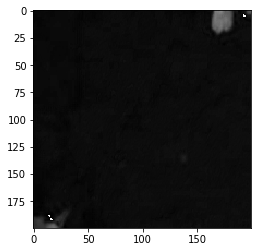

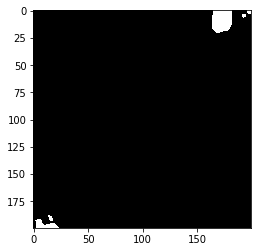

In [34]:
mexg_img = mexg(img)
imshow(mexg_img)

beet_th, mexg_binary_img = otsu_binarization(mexg_img)
imshow(mexg_binary_img)

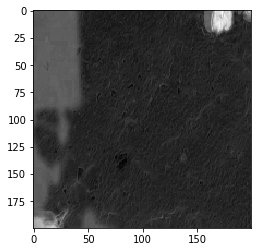

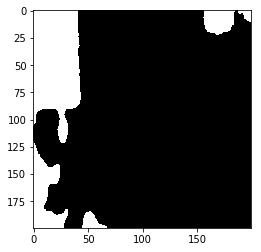

In [35]:
exgr_img = exgr(img)
imshow(exgr_img)

beet_th, exgr_binary_img = otsu_binarization(exgr_img)
imshow(exgr_binary_img)

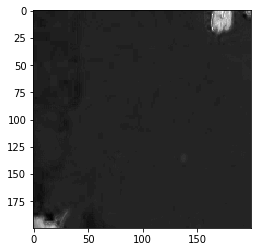

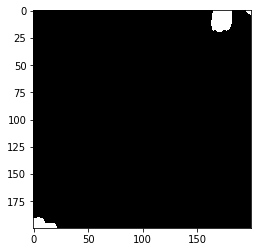

In [15]:
exg_img = exg(img)
imshow(exg_img)

beet_th, exg_binary_img = otsu_binarization(exg_img)
imshow(exg_binary_img)

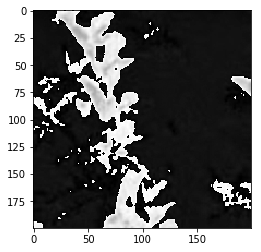

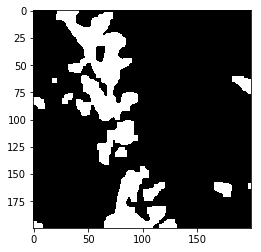

In [79]:
cive_img = cive(img)
imshow(cive_img)

cive_th, cive_binary_img = otsu_binarization(cive_img)
cive_binary_img = cv2.morphologyEx(cive_binary_img, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
imshow(cive_binary_img)

# Version 1

In [21]:
def plant_detect(path, verbose=False):
    # Read image
    img_cv = cv2.imread(path)
    img = img_cv[:, :, ::-1]
    imshow(img, verbose=verbose, gray=False)
    
    # Calculate enhanced image
    ndi_img = ndi(img)
    imshow(ndi_img, verbose=verbose)
    
    exg_img = exg(img)
    imshow(exg_img, verbose=verbose)
    
    # Segmentaion
    thistle_th, ndi_binary_img = otsu_binarization(ndi_img, verbose=verbose)
    imshow(ndi_binary_img, verbose=verbose)

    beet_th, exg_binary_img = otsu_binarization(exg_img, verbose=verbose)
    imshow(exg_binary_img, verbose=verbose)

    kernel = np.ones((5,5),np.uint8)
    exg_dilation_img = cv2.dilate(exg_binary_img,kernel,iterations = 1)
    mask = ((ndi_binary_img != 0) & (exg_dilation_img == 0))
    thistle_img = np.zeros_like(ndi_binary_img)
    thistle_img[mask] = 255
    imshow(thistle_img, verbose=verbose)
    
    #
    plant_img = np.copy(img)
    plant_img[ndi_binary_img==0]=[0, 0, 0]
    imshow(plant_img, verbose=verbose, gray=False)
    
    # Find contour
    img2 = np.copy(img)
    contours, _ = cv2.findContours(thistle_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        if w * h > 900:
            cv2.rectangle(img2, (x,y), (x+w,y+h), (0,255,0), 2)
            
    contours, _ = cv2.findContours(exg_binary_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        if w * h > 900:
            cv2.rectangle(img2, (x,y), (x+w,y+h), (255,0,0), 2)
            
    imshow(img2, verbose=verbose, gray=False)
    
    return img, img2, thistle_th, beet_th

132.0
139.0
132.0 139.0


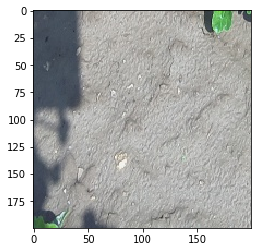

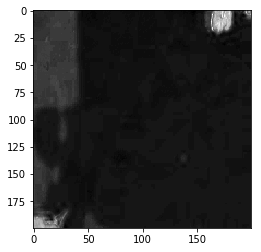

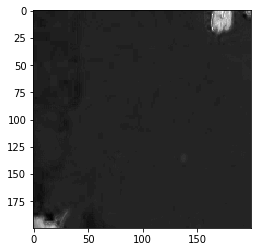

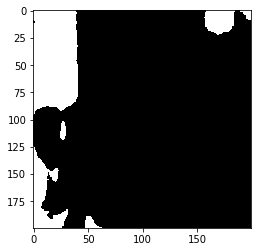

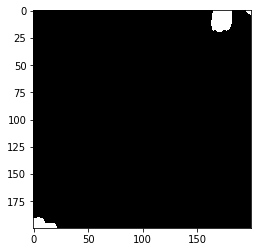

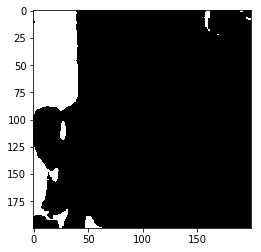

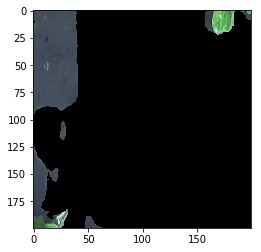

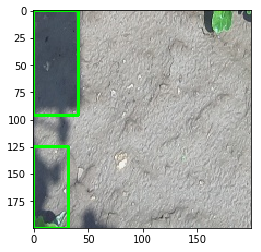

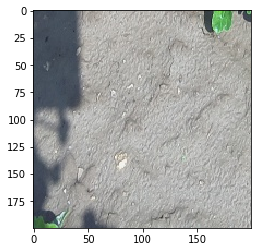

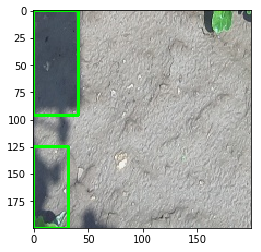

In [36]:
img, result, th1, th2 = plant_detect('data/im_109.jpg', verbose=True)
imshow(img, gray=False)
imshow(result, gray=False)
print(th1, th2)

In [38]:
data_path = 'data'
result_path = 'results'
thistle_th = []
beet_th = []
file_name = []

for file in tqdm(os.listdir(data_path)):
    if '.jpg' in file:
        img, result, th1, th2 = plant_detect(os.path.join(data_path, file))
#         fig, (ax1, ax2) = plt.subplots(1, 2)
#         ax1.imshow(img, cmap='gray')
#         ax2.imshow(result, cmap='gray')
        cv2.imwrite(os.path.join(result_path, file), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        
        file_name.append(file)
        thistle_th.append(th1)
        beet_th.append(th2)

100%|██████████| 480/480 [00:02<00:00, 161.06it/s]


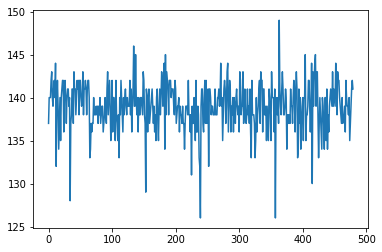

In [39]:
plt.plot(thistle_th)

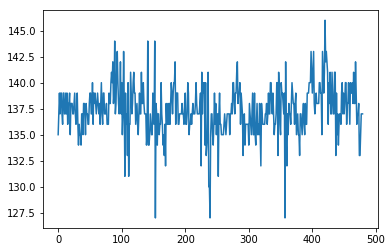

In [40]:
plt.plot(beet_th)

In [42]:
for i in range(len(thistle_th)):
    if thistle_th[i] <= 132:
        print(file_name[i], i, thistle_th[i])

im_109.jpg 12 132.0
im_13.jpg 34 128.0
im_220.jpg 153 129.0
im_29.jpg 225 131.0
im_301.jpg 238 132.0
im_302.jpg 239 126.0
im_315.jpg 252 132.0
im_414.jpg 357 126.0
im_47.jpg 415 130.0


In [43]:
thistle_th[358]

140.0

In [54]:
THISTLE_TH = 138
BEET_TH = 131
def plant_detect_v2(path, verbose=False):
    # Read image
    img_cv = cv2.imread(path)
    img = img_cv[:, :, ::-1]
    imshow(img, verbose=verbose, gray=False)
    
    # Calculate enhanced image
    ndi_img = ndi(img)
    imshow(ndi_img, verbose=verbose)
    
    exg_img = exg(img)
    imshow(exg_img, verbose=verbose)
    
    # Segmentaion
    kernel = np.ones((5,5),np.uint8)
    
    thistle_th, ndi_binary_img = otsu_binarization(ndi_img, verbose=verbose)
    if thistle_th < THISTLE_TH:
        thistle_th, ndi_binary_img = fixed_binarization(ndi_img, th=THISTLE_TH, verbose=verbose)
        ndi_binary_img = cv2.dilate(ndi_binary_img,kernel,iterations = 1)
    imshow(ndi_binary_img, verbose=verbose)

    beet_th, exg_binary_img = otsu_binarization(exg_img, verbose=verbose)
    if beet_th < BEET_TH:
        beet_th, exg_binary_img = fixed_binarization(exg_img, th=BEET_TH, verbose=verbose)
    imshow(exg_binary_img, verbose=verbose)

    exg_dilation_img = cv2.dilate(exg_binary_img,kernel,iterations = 1)
    mask = ((ndi_binary_img != 0) & (exg_dilation_img == 0))
    thistle_img = np.zeros_like(ndi_binary_img)
    thistle_img[mask] = 255
    thistle_img = cv2.morphologyEx(thistle_img, cv2.MORPH_OPEN, kernel)
    imshow(thistle_img, verbose=verbose)
    
    #
    plant_img = np.copy(img)
    plant_img[ndi_binary_img==0]=[0, 0, 0]
    imshow(plant_img, verbose=verbose, gray=False)
    
    # Find contour
    img2 = np.copy(img)
    contours, _ = cv2.findContours(thistle_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        if w * h > 900:
            cv2.rectangle(img2, (x,y), (x+w,y+h), (0,255,0), 2)
            
    contours, _ = cv2.findContours(exg_binary_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        if w * h > 900:
            cv2.rectangle(img2, (x,y), (x+w,y+h), (255,0,0), 2)
            
    imshow(img2, verbose=verbose, gray=False)
    
    return img, img2, thistle_th, beet_th

132.0
138.0
139.0
138.0 139.0


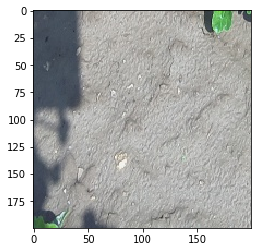

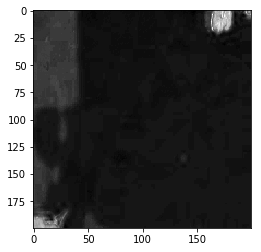

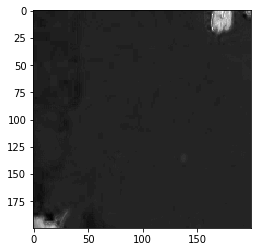

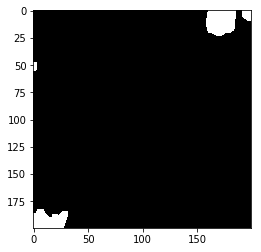

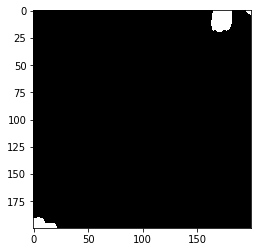

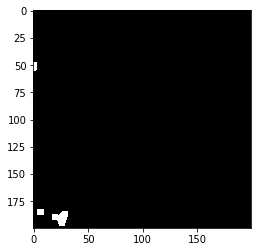

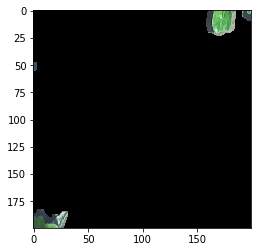

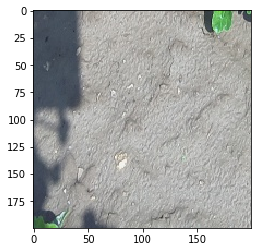

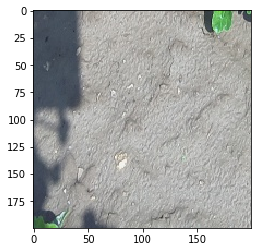

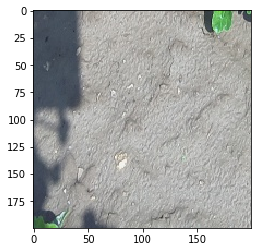

In [55]:
img, result, th1, th2 = plant_detect_v2('data/im_109.jpg', verbose=True)
imshow(img, gray=False)
imshow(result, gray=False)
print(th1, th2)

In [56]:
data_path = 'data'
result_path = 'results'
thistle_th = []
beet_th = []
file_name = []

for file in tqdm(os.listdir(data_path)):
    if '.jpg' in file:
        img, result, th1, th2 = plant_detect_v2(os.path.join(data_path, file))
#         fig, (ax1, ax2) = plt.subplots(1, 2)
#         ax1.imshow(img, cmap='gray')
#         ax2.imshow(result, cmap='gray')
        cv2.imwrite(os.path.join(result_path, file), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        
        file_name.append(file)
        thistle_th.append(th1)
        beet_th.append(th2)

100%|██████████| 480/480 [00:02<00:00, 164.82it/s]
